In [1]:
# Import necessary modules
import numpy as np
import os
import pandas as pd
import pickle
import sys

here = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(here, '../../'))
sys.path.insert(0, project_root)

from core.ga.ga_bounds import DesignSpaceBounds
from core.ga.ga_params import GeneticAlgorithmParams
from core.ga.ga import GeneticAlgorithm

from core.model.model_carrying_capacities import ModelCarryingCapacities
from core.model.model_disturbances import ModelDisturbances
from core.model.model_growth_rates import ModelGrowthRates
from core.model.model_initial_conditions import ModelInitialConditions
from core.model.model_params import ModelParams
from core.model.model_typical_disturbances import ModelTypicalDisturbances
from core.model.model_sensitivities import ModelSensitivities

from ga_member_cpp import Evaluator

In [2]:
input_key = 10

## Model Parameters

In [3]:
# Set ModelParams (time stepping)
model_params = ModelParams(
    dt               = 1.0,  # hours/step
    simulation_hours = 2900, # hours
    verbose          = True  # for the single simulation
)

In [4]:
# Set ModelCarryingCapacities
carrying_capacities = ModelCarryingCapacities(
    kh = 3.0,  # m
    kA = 0.65, # m2
    kN = 20,   # number of leaves
    kc = 1000, # number of spikelets
    kP = 0.25  # kg
)

In [5]:
# Set ModelGrowthRates
growth_rates = ModelGrowthRates(
    ah = 0.01,   # 1/hr
    aA = 0.0105, # 1/hr
    aN = 0.011,  # 1/hr
    ac = 0.01,   # 1/hr
    aP = 0.005   # 1/hr
)

In [6]:
# Set ModelSensitivities
sensitivities = ModelSensitivities(
    sigma_W = 30,  # hrs
    sigma_F = 300, # hrs
    sigma_T = 30,  # hrs
    sigma_R = 30   # hrs
)

In [7]:
# Set ModelInitialConditions
initial_conditions = ModelInitialConditions(
    h0=carrying_capacities.kh/model_params.simulation_hours, # m/hr
    A0=carrying_capacities.kA/model_params.simulation_hours, # m2/hr
    N0=carrying_capacities.kN/model_params.simulation_hours, # number/hr
    c0=carrying_capacities.kc/model_params.simulation_hours, # number/hr
    P0=carrying_capacities.kP/model_params.simulation_hours  # kg/hr
)

## Design Space

In [8]:
lower_bounds_dict = {
    "irrigation_frequency":    12, # once every X hours
    "irrigation_amount":       0,  # inches per irrigation
    "fertilization_frequency": 24, # once every X hours (once a day)
    "fertilization_amount":    0   # pounds per fertilization
}
lower_bounds = np.array([value for key, value in lower_bounds_dict.items()])

In [9]:
upper_bounds_dict = {
    "irrigation_frequency":    2900,  # once a season
    "irrigation_amount":       10,    # inches per irrigation
    "fertilization_frequency": 2900,  # once a season
    "fertilization_amount":    700    # pounds per fertilization
}
upper_bounds = np.array([value for key, value in upper_bounds_dict.items()])

In [10]:
# Set DesignSpaceBounds
bounds = DesignSpaceBounds(
    lower_bounds=lower_bounds,
    upper_bounds=upper_bounds
)

## Genetic Algorithm Parameters

In [11]:
# Genetic algorithm style inputs
ga_params = GeneticAlgorithmParams(
    num_parents     = 16,  # number of design strings to breed
    num_kids        = 16,  # number of offspring design strings
    num_generations = 100, # number of generations
    num_members     = 128, # number of simulations per generation
)

## Input Disturbances

In [12]:
# Hourly precipitation, radiation, and temperature from CSV
hourly_input_disturbances = pd.read_csv(
    '../../io/inputs/hourly_prcp_rad_temp_iowa.csv'
)

In [13]:
# Set ModelDisturbances
input_disturbances = ModelDisturbances(
    precipitation = 0.5*hourly_input_disturbances['Hourly Precipitation (in)'].to_numpy(), # drought year
    radiation     = hourly_input_disturbances['Hourly Radiation (W/m2)'].to_numpy(),
    temperature   = hourly_input_disturbances['Temperature (C)'].to_numpy()
)

## Optimal/Typical Values

In [14]:
default_typical_disturbances = ModelTypicalDisturbances()

typical_disturbances = ModelTypicalDisturbances(
    typical_water       = default_typical_disturbances.typical_water       * model_params.dt,
    typical_fertilizer  = default_typical_disturbances.typical_fertilizer  * model_params.dt,
    typical_temperature = default_typical_disturbances.typical_temperature * model_params.dt,
    typical_radiation   = default_typical_disturbances.typical_radiation   * model_params.dt
)

## Single simulation

In [15]:
# Carla test params
irrigation_frequency = 24 * 7 * 2  # Irrigate once every 336 hours
irrigation_amount    = 0.23        # with 0.23 inches per irrigation (goal is 28 in including precip)
fertilizer_frequency = 24 * 30 * 3 # Fertilize once every 2160 hours
fertilizer_amount    = 175         # with 175 lbs per fertilization (goal is 355 lbs over season)

'''
# Example bad params
irrigation_frequency = 1
irrigation_amount    = 0
fertilizer_frequency = 1
fertilizer_amount    = 0
'''

'\n# Example bad params\nirrigation_frequency = 1\nirrigation_amount    = 0\nfertilizer_frequency = 1\nfertilizer_amount    = 0\n'

In [16]:
# Construct a single-member population Evaluator
from core.ga.ga_population import Population
population = Population(
    bounds               = bounds,
    ga_params            = ga_params,
    carrying_capacities  = carrying_capacities,
    disturbances         = input_disturbances,
    growth_rates         = growth_rates,
    initial_conditions   = initial_conditions,
    model_params         = model_params,
    typical_disturbances = typical_disturbances,
    sensitivities        = sensitivities,
    values = np.array([[irrigation_frequency, irrigation_amount, fertilizer_frequency, fertilizer_amount]])
)

In [17]:
population.set_costs_with_cpp()
cost_cpp = population.costs[0]
print(f"Cost from C++ Evaluator: {cost_cpp}")

Time taken to evaluate population with C++ evaluator: 0.003020048141479492 seconds
Cost from C++ Evaluator: -465.605737525557


In [18]:
population.set_costs()
cost_py = population.costs[0]
print(f"Cost from Python Evaluator: {cost_py}")

Cost from Python Evaluator: -468.61545509199976


In [19]:
import time, numpy as np

# 1) context build
t0 = time.perf_counter()
ctx = population._build_sim_context_dict_cpp()
t1 = time.perf_counter()

# 2) evaluator construction
from ga_member_cpp import Evaluator
ev = Evaluator(ctx)
t2 = time.perf_counter()

# 3) evaluation (all 128)
X = np.ascontiguousarray(population.values, dtype=np.float64)  # IMPORTANT
costs = ev.evaluate_population(X)
t3 = time.perf_counter()

print("build ctx:", t1-t0)
print("make eval:", t2-t1)
print("eval pop :", t3-t2)


build ctx: 0.0028475411236286163
make eval: 0.0018965420313179493
eval pop : 0.0029873750172555447


## Genetic Algorithm

In [20]:
# Set verbose to False for GA runs
model_params.verbose = False

# Create GeneticAlgorithm object from all inputs
GeneticAlgorithm = GeneticAlgorithm(
    bounds               = bounds,
    ga_params            = ga_params,
    model_params         = model_params,
    carrying_capacities  = carrying_capacities,
    growth_rates         = growth_rates,
    initial_conditions   = initial_conditions,
    disturbances         = input_disturbances,
    typical_disturbances = typical_disturbances,
    sensitivities        = sensitivities
)

In [21]:
# Run the Genetic Algorithm and save the result

GeneticAlgorithmResult = GeneticAlgorithm.run_with_cpp()

with open(f"ga_parallel_results/pickled_ga_results/ga_parallel_result_{input_key}.pkl", "wb") as f:
    pickle.dump(GeneticAlgorithmResult, f)


Time taken to evaluate population with C++ evaluator: 0.38182806968688965 seconds
Time taken to calculate costs for g=0: 0.3861660957336426 seconds
Generation 2 of 100
Time taken to breed kids for g=1: 0.0001251697540283203 seconds
Time taken to fill random members for g=1: 0.000518798828125 seconds
Time taken to evaluate population with C++ evaluator: 0.378756046295166 seconds
Time taken to calculate costs for g=1: 0.3824129104614258 seconds
Lowest cost in generation 1: -840.91
Time taken to sort population for g=1: 2.47955322265625e-05 seconds
Generation 3 of 100
Time taken to breed kids for g=2: 8.821487426757812e-05 seconds
Time taken to fill random members for g=2: 0.0007469654083251953 seconds
Time taken to evaluate population with C++ evaluator: 0.3798031806945801 seconds
Time taken to calculate costs for g=2: 0.3836207389831543 seconds
Lowest cost in generation 2: -840.91
Time taken to sort population for g=2: 1.7881393432617188e-05 seconds
Generation 4 of 100
Time taken to bre

In [22]:
with open(f"ga_parallel_results/pickled_ga_results/ga_parallel_result_{input_key}.pkl", "rb") as f:
    result = pickle.load(f)

In [23]:
[unique_values, unique_costs] = result.final_population.get_unique_designs()

In [24]:
unique_values_df = pd.DataFrame({
    'Irrigation frequency (every X hours)': unique_values[:, 0],
    'Irrigation amount (in)':               unique_values[:, 1],
    'Fertilizer frequency (every X hours)': unique_values[:, 2],
    'Fertilizer amount (lb)':               unique_values[:, 3],
    'Cost ($)':                             unique_costs,
    'Revenue ($)':                          -unique_costs,
})
unique_values_df.to_csv(f'ga_parallel_results/unique_values_costs_results/ga_parallel_result_unique_values_and_costs_{input_key}.csv', index=False)

In [25]:
#result.print_table_of_best_designs()

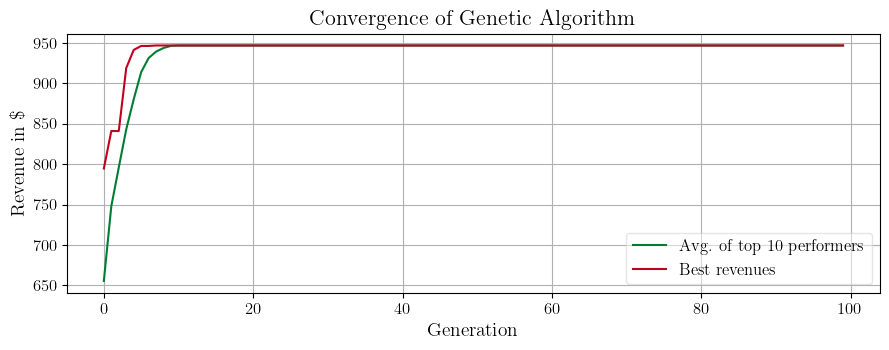

In [26]:
result.plot_optimization_results()

In [27]:
min(unique_costs)

np.float64(-975.3519320753132)